DSBA-6165 - Project - Stage 5<br>
Final Model Bikash Khadka<br><br>
Group 2:<br>
<li>Seve Jimenez<br>
<li>Bikash Khadka<br>
<li>Michael Tricanowicz

# Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import torch

In [2]:
# Set global random state variable
random_state = 20256165

## Load the Balanced Dataset

Load the dataset from the created PyTorch file.

In [3]:
# Load the dataset
data = torch.load("balanced_dataset.pt")
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [4]:
# Check number of images
print(len(data))

2147


## Split Images and Labels

In [5]:
# Create an index for the data to use as a link to original set once train/test split is done
index = np.arange(len(data))

In [6]:
# Extract images as the independent feature
X = torch.stack([img.squeeze(0) for _, (labels, img) in data.items()])  # Remove extra dim

In [7]:
# Create a mapping of the labels with "Not Labeled" included
unique_labels = sorted(set(label for labels, _ in data.values() for label in (labels if labels else ["Not Labeled"])))  
label_to_idx = {label: i for i, label in enumerate(unique_labels)}

In [8]:
# Extract labels as the dependent feature as a multi-hot encoded vector
y = torch.zeros((len(data), len(unique_labels)), dtype=torch.float32)
for i, (labels, _) in enumerate(data.values()):
    if not labels:
        y[i, label_to_idx["Not Labeled"]] = 1  # Assign "Not Labeled" class
    else:
        for label in labels:
            y[i, label_to_idx[label]] = 1  # Assign correct labels

## Confirm the count and visualize the class distribution in the dataset

In [9]:
# Define function to count labels and store in dictionary
def label_count(y):
    label_count = torch.zeros(y.shape[1], dtype=torch.int32)
    for i in range(len(y)):
        for j in range(len(y[i])):
            label_count[j] += y[i][j].int()
    return {label: int(label_count[idx]) for label, idx in label_to_idx.items()}

In [10]:
# Define function to plot histogram of label counts
import seaborn as sns
def plot_label_counts(y, y2=None):
    plt.figure(figsize=(10, 5))
    if y2 is not None:
        label_to_count_y = label_count(y)
        label_to_count_y2 = label_count(y2)
        counts_df = pd.DataFrame({
            "Class": label_to_count_y.keys(),
            "Train": label_to_count_y.values(),
            "Test": label_to_count_y2.values()
        })
        counts_df = counts_df.melt(id_vars="Class", var_name="Dataset", value_name="Count")
        ax = sns.barplot(data=counts_df, x="Class", y="Count", hue="Dataset")
    else:
        label_to_count = label_count(y)
        ax = sns.barplot(x=list(label_to_count.keys()), y=list(label_to_count.values()))
    plt.xlabel("Label", fontsize=12)
    plt.ylabel("Count of Images", fontsize=12)
    plt.title("Distribution of Labels in Dataset", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    # Annotate bars with counts
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',  # set the annotation to the height (value) of the bar
            (p.get_x() + p.get_width() / 2, p.get_height()),  # center annotation at the top of the bar
            ha='center',
            va='bottom'
        )
    plt.show()

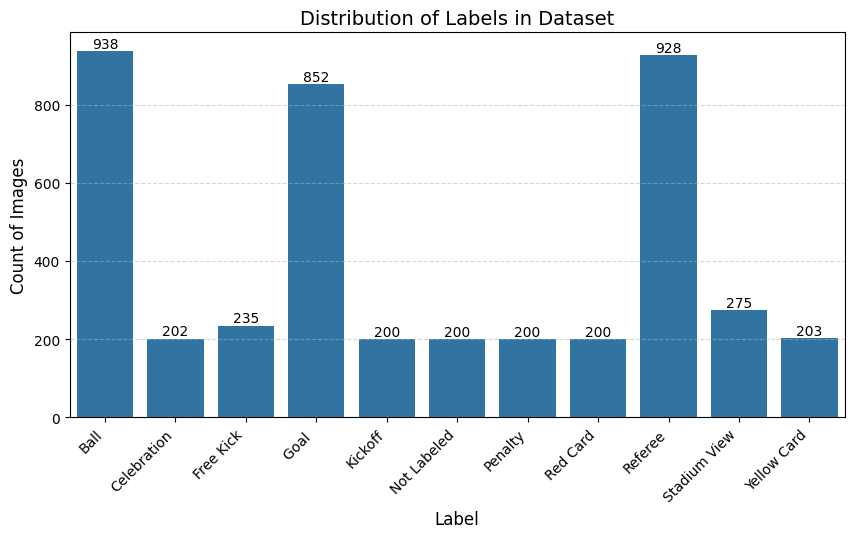

In [11]:
# Plot the labels
plot_label_counts(y)

## Create train and test datasets

In [12]:
# Prepare to split into train and test datasets for modeling
from sklearn.model_selection import train_test_split # import necesary library
test_size = 0.20 # global test size variable

In [13]:
# Import additional torch modules
from torch.utils.data import TensorDataset, DataLoader, random_split

In [14]:
# Train-test split
index_train, index_test, X_train, X_test, y_train, y_test = train_test_split(index, X, y, test_size=test_size, random_state=random_state)

In [15]:
print("X_train shape:", X_train.shape)  # check shape of the train X array which should be (num_samples, num channels, img_dim, img_dim)
print("X_test shape:", X_test.shape)  # check shape of the test X array which should be (num_samples, num channels, img_dim, img_dim)
print("y_train length:", len(y_train)) # check train label length which should be num_samples
print("y_test length:", len(y_test)) # check test label length which should be num_samples

X_train shape: torch.Size([1717, 3, 224, 224])
X_test shape: torch.Size([430, 3, 224, 224])
y_train length: 1717
y_test length: 430


In [16]:
# Use TensorDataset instead for loading via DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

## Count and visualize the class distribution between train and test sets

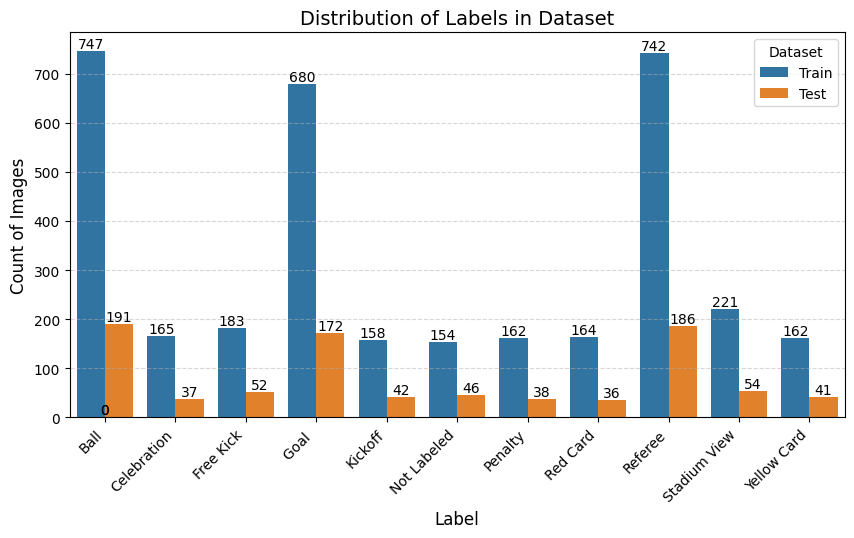

In [17]:
# Plot comparison of label distribution between the train and test sets
plot_label_counts(y_train, y_test)

## Visualize some images to confirm successful prep

In [18]:
# Define function to show an image where x is an image
def show_img(x, title="", bot="", fontsize=10):
    if isinstance(x, torch.Tensor):  # check whether the image is in tensor formate
        x = x.detach().cpu().numpy()  # if it is convert to NumPy and ensure it is moved to CPU
    if x.ndim == 3 and x.shape[0] in [1, 3]:  
        x = x.transpose(1, 2, 0)  # convert from (C, H, W) to (H, W, C) to work with imshow
    plt.imshow(x)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel(bot, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.plot()

In [19]:
# Define function to revert the multi-hot encoded label index to the labels that are present for display
def present_labels(y):
    present_labels = []
    index_to_label = {v: k for k, v in label_to_idx.items()}
    present_labels = [index_to_label[i] for i, value in enumerate(y) if value == 1]
    return present_labels

In [21]:
# Define function to show some number of images where X is an array of images, y is an array of labels, and n_images is the number of images to be displayed
import math
def display_images(X, y, index, n_images, data):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j=0
    for i in random.sample(range(len(X)), n_images):
        # Plot images with labels
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(
            X[i],
            title=", ".join(label.strip() for label in present_labels(y[i])),
            bot=f"Image {list(data.keys())[index[i]]}" # Note, the image # is from the image dictionary and comes from the filename in the original dataset
            )
        plt.plot()
        j += 1
    plt.tight_layout()

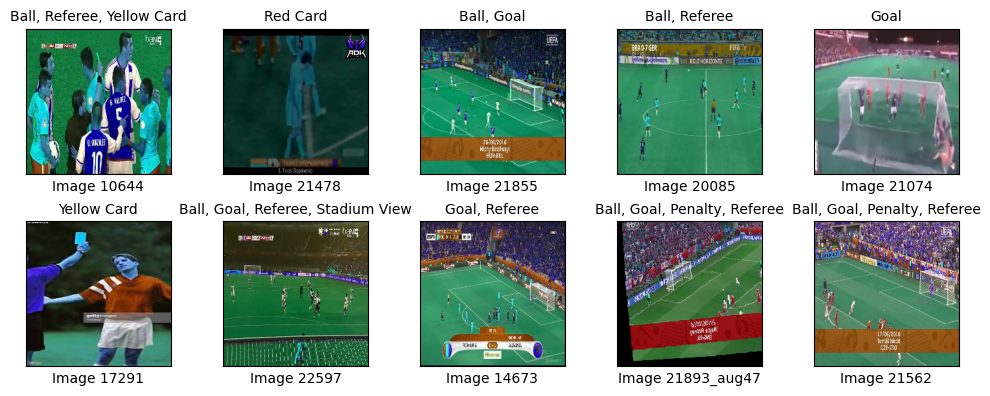

In [22]:
# Preview Train data
# Set the number images to preview
n_images_train = 10
# Show the images
display_images(X_train, y_train, index_train, n_images_train, data)

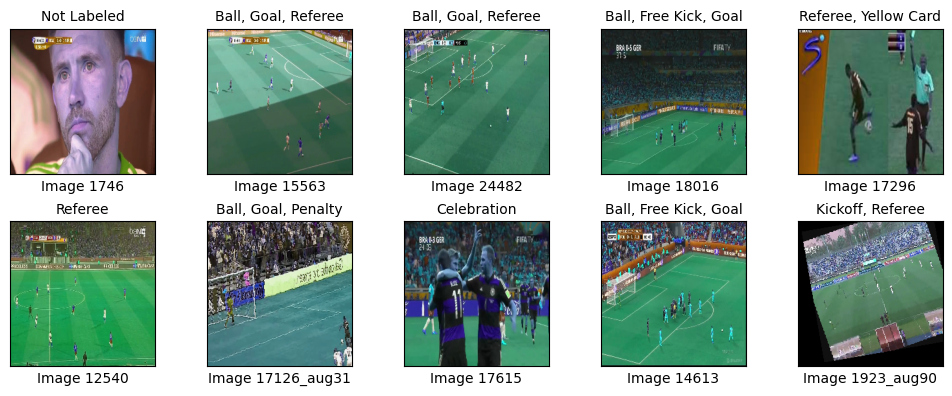

In [23]:
# Preview Test data
# Set the number images to preview
n_images_test = 10
# Show the images
display_images(X_test, y_test, index_test, n_images_test, data)

# Model

## Setup

In [24]:
# Import additional Torch libraries
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

In [25]:
# Create global batch size variable
batch_size = 32

In [26]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [27]:
# Check DataLoader output
for imgs, labels in train_loader:
    print(imgs.shape, labels.shape)  # Expected: torch.Size([batch_size, channels (3), height (224), width (224)]) torch.Size([batch_size, num_labels (11)])
    break

torch.Size([32, 3, 224, 224]) torch.Size([32, 11])


In [28]:
# Check which device is available and being used. Use GPU if available.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Define and Build Model

For the baseline model, a CNN was created using PyTorch to mimic the structure and architecture of the LeNet-5 model as shown in Figure 27 of the Lecture 6 slides. Adjustments were made to account for the different input size. LeNet-5 was built for grayscale 28x28 images, but this model is evaluating RGB 224x224 images.

Now, in order to improve the performance from the baseline model, we use a more advanced architecture to train our model. For this, I chose the VGG16 architecture to this model and name it BikashVGGNet. One of this reason I chose this is because of computational efficiency, considering the input size (224*224*3) and multi-labeled output. 

Some of the modifications in the BikashVGGNet include:

1. Architecture:
    * There are 5 convolutional blocks with 3*3 convolutions with increasing filter sizes (64, 128, 256, 512, 512). Also, each block has a 2-3 convolutional block followed by a 2*2 max pooling layer with a stride of 2.
    * There are 3 dense layers along with dropout (0.5) to prevent overfitting.
    * The final layer outputs num_labels logits for multilabel classification BCEWithLogitsLoss

2. Hyperparameters:
    * The learning rate was lowered to 0.0001 from the baseline model which had a learning rate of 0.001. The reason being was to ensure stable training for the deeper model.
    * The epochs was increased to 20 epochs despite computational challenges as deeper models require more training iterations.
    * The optimizer was kept the same as the baseline model which was Adam.

3. The model used the same train_loader and test_loader with the baseline model in order to compare with our other models. 

In [29]:
# Defining BikashVGGNet based on VGG16 architecture
class BikashVGGNet(nn.Module):
    def __init__(self, num_labels):
        super(BikashVGGNet, self).__init__()
        
        # Convolutional layers (inspired by VGG16)
        self.features = nn.Sequential(
            # Block 1: 2 conv layers, 64 filters
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 224x224 -> 112x112
            
            # Block 2: 2 conv layers, 128 filters
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 112x112 -> 56x56
            
            # Block 3: 3 conv layers, 256 filters
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 56x56 -> 28x28
            
            # Block 4: 3 conv layers, 512 filters
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 28x28 -> 14x14
            
            # Block 5: 3 conv layers, 512 filters
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14x14 -> 7x7
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_labels),  # Output layer for multi-label classification
        )
        
    def forward(self, x):
        x = self.features(x)  # Apply convolutional blocks
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 512 * 7 * 7)
        x = self.classifier(x)  # Apply fully connected layers
        return x

In [30]:
# Review the model's structure
summary(BikashVGGNet(len(label_to_idx.keys())), input_size=(3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [31]:
# Initialize the model and move to device
model = BikashVGGNet(len(label_to_idx.keys()))
model.to(device)

BikashVGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [32]:
# Set hyperparameters (adjusted for deeper model)
learning_rate = 0.0001  # Lower learning rate for stability
epochs = 20  # More epochs due to deeper architecture
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

**Train Model**

In [33]:
# Train the model
train_losses = []
for epoch in range(epochs):
    epoch_loss = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.float().to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    epoch_loss /= len(train_loader)
    print(f'Epoch [{epoch + 1}/{epochs}] Epoch Loss: {epoch_loss:.4f}')
    train_losses.append(epoch_loss)

Epoch [1/20], Step [10/54], Loss: 0.4635
Epoch [1/20], Step [20/54], Loss: 0.4176
Epoch [1/20], Step [30/54], Loss: 0.4247
Epoch [1/20], Step [40/54], Loss: 0.4526
Epoch [1/20], Step [50/54], Loss: 0.4200
Epoch [1/20] Epoch Loss: 0.4585
Epoch [2/20], Step [10/54], Loss: 0.4248
Epoch [2/20], Step [20/54], Loss: 0.4113
Epoch [2/20], Step [30/54], Loss: 0.4311
Epoch [2/20], Step [40/54], Loss: 0.4128
Epoch [2/20], Step [50/54], Loss: 0.4277
Epoch [2/20] Epoch Loss: 0.4242
Epoch [3/20], Step [10/54], Loss: 0.4353
Epoch [3/20], Step [20/54], Loss: 0.4320
Epoch [3/20], Step [30/54], Loss: 0.4385
Epoch [3/20], Step [40/54], Loss: 0.4435
Epoch [3/20], Step [50/54], Loss: 0.4223
Epoch [3/20] Epoch Loss: 0.4237
Epoch [4/20], Step [10/54], Loss: 0.3893
Epoch [4/20], Step [20/54], Loss: 0.4441
Epoch [4/20], Step [30/54], Loss: 0.4314
Epoch [4/20], Step [40/54], Loss: 0.3832
Epoch [4/20], Step [50/54], Loss: 0.4110
Epoch [4/20] Epoch Loss: 0.4244
Epoch [5/20], Step [10/54], Loss: 0.3883
Epoch [5/20

The model took extremely long amount of time to train. Since, GPU was not available, it took about 325 minutes to train the model over 20 epochs.

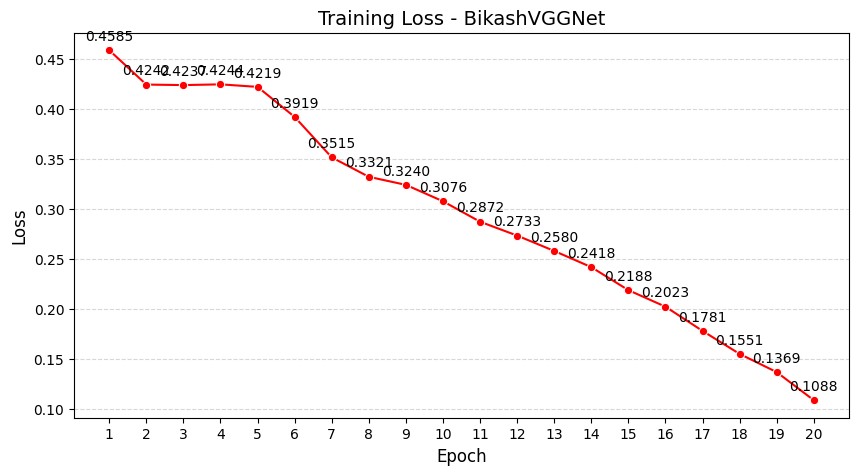

In [34]:
# Plot training loss
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=range(1, epochs+1), y=train_losses, color="red", marker="o")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss - BikashVGGNet", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(range(1, epochs+1))
for epoch, loss in zip(range(1, epochs+1), train_losses):
    ax.annotate(
        f'{loss:.4f}',
        (epoch, loss),
        textcoords="offset points",
        xytext=(0, 5),
        ha="center",
        va="bottom"
    )
plt.show()

**Test Model**

In [35]:
# Test the model
correct, total = 0, 0
test_images = []
test_labels = []
predictions = []
threshold = 0.5

with torch.no_grad():
    model.eval()
    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.float().to(device), labels.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        predicted = (probs > threshold).float()
        
        total += labels.numel()
        correct += (predicted == labels).sum().item()
        
        test_images.append(images)
        test_labels.append(labels)
        predictions.append(predicted)

print(f"Accuracy on the test set: {correct/total:.2%}")

Accuracy on the test set: 90.11%


This model performed better over the baseline model as the accuracy on the test data increased to 90.11%.

In [51]:
# Redefine label_to_idx and idx_to_label (from your original preprocessing)
unique_labels = sorted(set(label for labels, _ in data.values() for label in (labels if labels else ["Not Labeled"])))
label_to_idx = {label: i for i, label in enumerate(unique_labels)}
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Define required functions from your original code
def show_img(x, title="", bot="", fontsize=10):
    if isinstance(x, torch.Tensor):  # check whether the image is in tensor format
        x = x.detach().cpu().numpy()  # convert to NumPy and ensure it is moved to CPU
    if x.ndim == 3 and x.shape[0] in [1, 3]:  
        x = x.transpose(1, 2, 0)  # convert from (C, H, W) to (H, W, C) for imshow
    plt.imshow(x)
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    plt.xlabel(bot, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.plot()

def present_labels(y):
    return [idx_to_label[i] for i, value in enumerate(y) if value == 1]

def display_predictions(X, predicted, actual, index, n_images, fontsize=10):
    plt.figure(figsize=(10 if n_images>=5 else 2*n_images, 2*math.ceil(n_images/5)))
    j = 0
    X = X.cpu()
    predicted = predicted.cpu().tolist()
    actual = actual.cpu().tolist()
    random.seed(20256165)  # Ensure consistent sampling
    for i in random.sample(range(len(X)), n_images):
        plt.subplot(math.ceil(n_images/5), 5 if n_images>=5 else n_images, j+1)
        show_img(
            X[i],
            title=f"Predicted: {', '.join(present_labels(predicted[i]))}",
            bot=f"Actual: {', '.join(present_labels(actual[i]))}\nImage {list(data.keys())[index[i]]}",
            fontsize=fontsize
        )
        plt.plot()
        j += 1
    plt.tight_layout()
    plt.show()

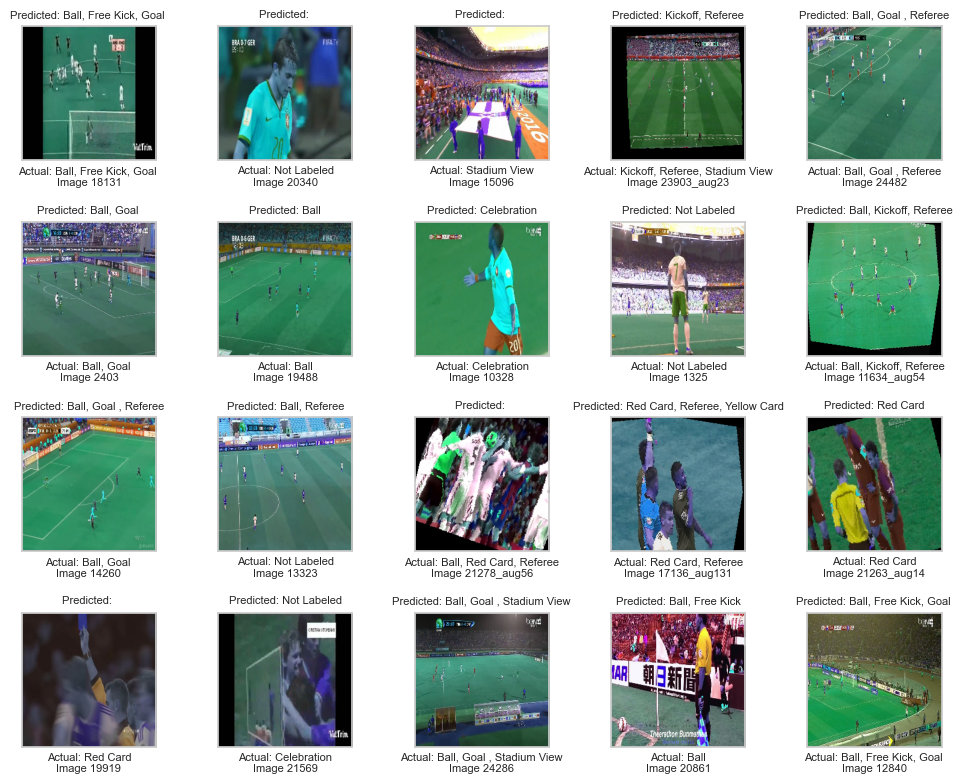

In [53]:
from sklearn.metrics import multilabel_confusion_matrix, classification_report

# Visualize predictions
n_images_pred = 20
display_predictions(torch.cat(test_images), torch.cat(predictions), torch.cat(test_labels), index_test, n_images_pred, fontsize=8)

# Generate and display classification metrics
confusion_matrices = multilabel_confusion_matrix(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu())
report = classification_report(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu(), zero_division=np.nan, labels=list(idx_to_label.keys()), target_names=list(idx_to_label.values()), output_dict=True)
report_display = classification_report(torch.cat(test_labels).cpu(), torch.cat(predictions).cpu(), zero_division=np.nan, labels=list(idx_to_label.keys()), target_names=list(idx_to_label.values()), output_dict=False)


In [55]:
print(report_display)

              precision    recall  f1-score   support

        Ball       0.73      0.79      0.76       191
 Celebration       0.61      0.46      0.52        37
   Free Kick       0.63      0.75      0.68        52
       Goal        0.83      0.81      0.82       172
     Kickoff       0.88      0.71      0.79        42
 Not Labeled       0.64      0.46      0.53        46
     Penalty       0.94      0.87      0.90        38
    Red Card       0.85      0.61      0.71        36
     Referee       0.72      0.75      0.73       186
Stadium View       0.70      0.61      0.65        54
 Yellow Card       0.69      0.54      0.60        41

   micro avg       0.75      0.72      0.73       895
   macro avg       0.75      0.67      0.70       895
weighted avg       0.75      0.72      0.73       895
 samples avg       0.72      0.67      0.65       895



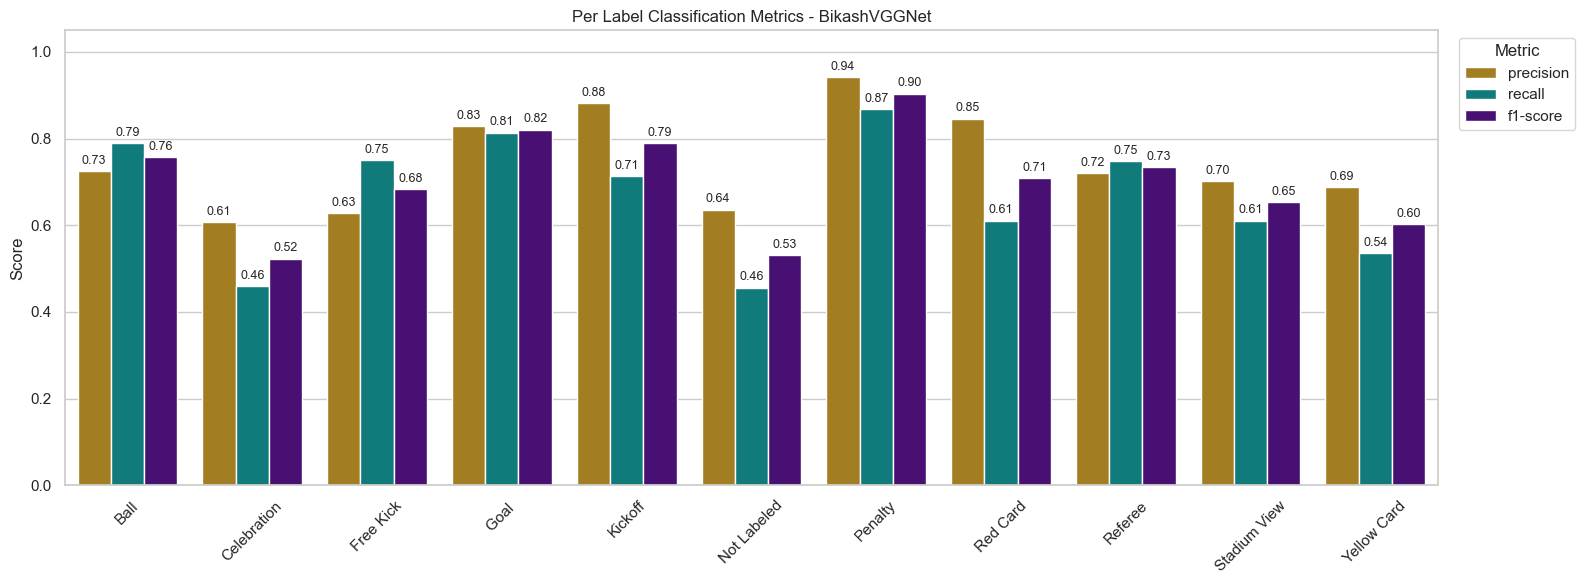

In [49]:

# Plot classification metrics
report_df = pd.DataFrame(report).transpose()
report_df = report_df.loc[unique_labels, ["precision", "recall", "f1-score"]]
report_df = report_df.reset_index().rename(columns={"index": "label"})
report_df_melt = report_df.melt(id_vars="label", var_name="metric", value_name='score')

plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
ax = sns.barplot(data=report_df_melt, x="label", y="score", hue="metric", palette=["darkgoldenrod", "darkcyan", "indigo"])
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)
plt.title("Per Label Classification Metrics - BikashVGGNet")
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=45)
plt.ylim(0, 1.05)
plt.legend(title="Metric", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.show()

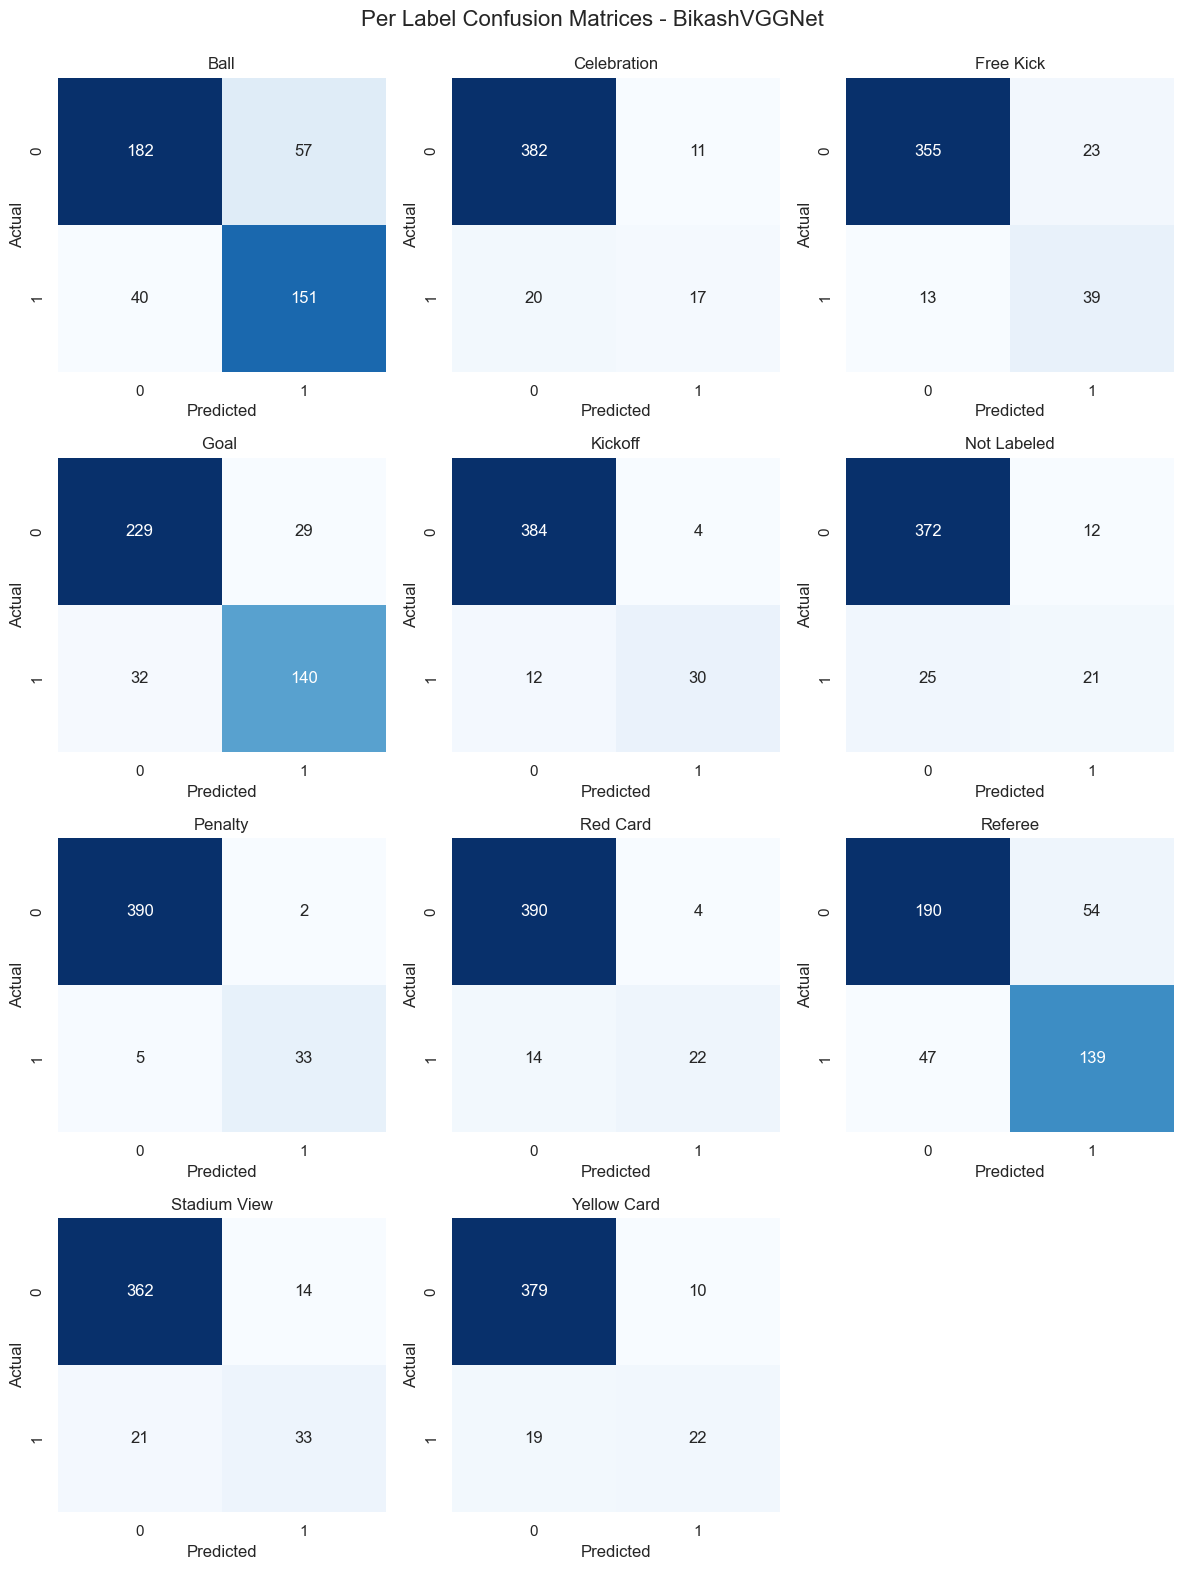

In [50]:
# Plot confusion matrices
plot_rows = 4
plot_cols = math.ceil(len(confusion_matrices)/plot_rows)
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(4*plot_cols, 4*plot_rows))
axes = axes.flatten()
for i, (matrix, label) in enumerate(zip(confusion_matrices, unique_labels)):
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
    axes[i].set_title(f"{idx_to_label[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
fig.suptitle("Per Label Confusion Matrices - BikashVGGNet\n", fontsize=16)
plt.tight_layout()
plt.show()